In [1]:
# Import Library
import torch
import torch.nn as nn
import torchvision 
from torchvision import transforms, models
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import save_image
import os

In [5]:
# image path ---- only change this for your photo
content_img_path = 'blue-moon-lake.jpg'
style_img_path = 'style2.jpg'

(1200, 1920, 3)


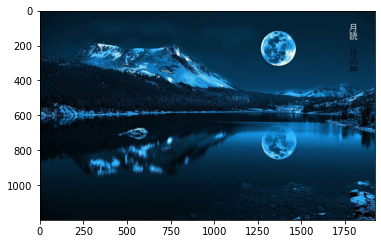

In [6]:
# Content Image
content_image = plt.imread(content_img_path)
plt.imshow(content_image)
print(content_image.shape)

(640, 1024, 3)


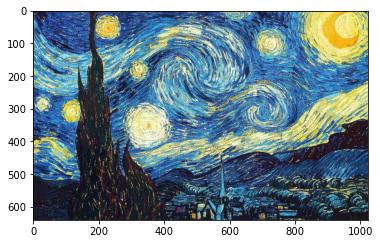

In [7]:
# Style Image
style_image = plt.imread(style_img_path)
plt.imshow(style_image)
print(style_image.shape)

In [8]:
# GPU setup 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
# get resized and transform image
def get_image(path, img_transform, size=(960, 660)):     # set size as your requirement
    image = Image.open(path)
    image = image.resize(size, Image.LANCZOS)
#     image = image/255
    image = img_transform(image).unsqueeze(0)
    return image.to(device)

# get gram matrix to calculate style loss
def get_gram(m):
    """
    input: m is shape of (1, 3, h, w)
    return: m.mT
    """
    _, c, h, w = m.size()
    m = m.view(c, h*w)
    m = torch.mm(m, m.t())
    return m

# Denormalized image to plot and save 
def denormalize(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp


In [10]:
# Setup NST CNN architecture----> used VGG16 pre-trained model here
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.selected_layers = [3, 8, 15, 22]
        self.vgg = models.vgg16(pretrained=True).features
        
    def forward(self, x):
        layer_feats = []
        for i, layer in self.vgg._modules.items():
            x = layer(x)
            if int(i) in self.selected_layers:
                layer_feats.append(x)
        return layer_feats

In [11]:
# set parameter
img_transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                                       std = [0.229, 0.224, 0.225])])

content_img = get_image(content_img_path, img_transform)
style_img = get_image(style_img_path, img_transform)
generate_img = content_img.clone()
generate_img.requires_grad = True


# save photo
sample_dir = 'results_NST'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [12]:
# optimizer 
optimizer = torch.optim.Adam([generate_img], lr=0.2, betas=[0.9, 0.999])

#encoder 
encoder = FeatureExtractor().to(device)
for p in encoder.parameters():
    p.requires_grad = False

Epoch: [0]	 Content Loss: 0.0000	 Style Loss: 84226.1328	


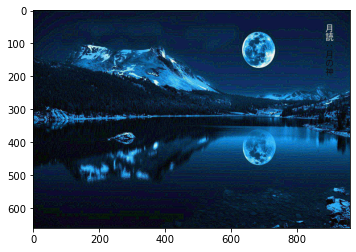

Epoch: [50]	 Content Loss: 1.3925	 Style Loss: 287.4901	


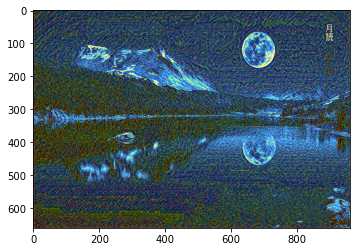

Epoch: [100]	 Content Loss: 1.0565	 Style Loss: 112.7182	


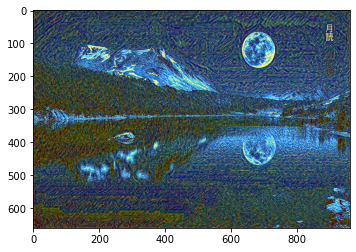

Epoch: [150]	 Content Loss: 0.9153	 Style Loss: 64.7766	


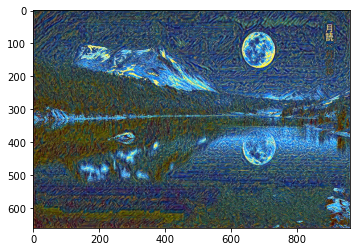

Epoch: [200]	 Content Loss: 0.8225	 Style Loss: 43.2683	


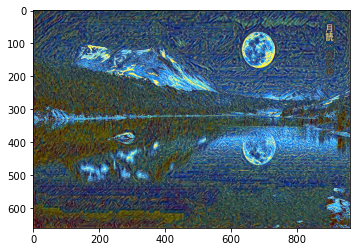

Epoch: [250]	 Content Loss: 0.7527	 Style Loss: 31.6804	


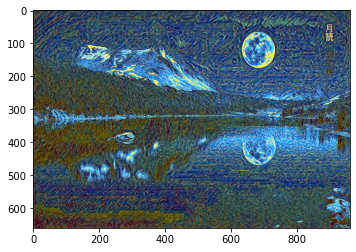

Epoch: [300]	 Content Loss: 0.6970	 Style Loss: 24.6751	


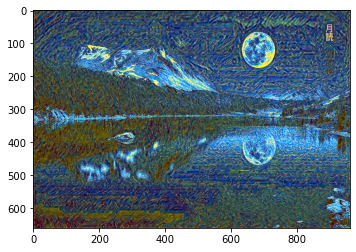

Epoch: [350]	 Content Loss: 0.6525	 Style Loss: 20.0705	


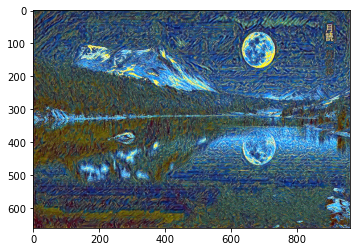

Epoch: [400]	 Content Loss: 0.6155	 Style Loss: 16.8512	


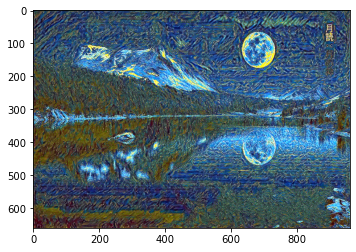

Epoch: [450]	 Content Loss: 0.5841	 Style Loss: 14.4824	


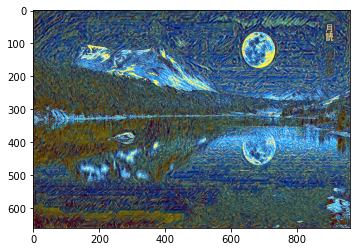

Epoch: [500]	 Content Loss: 0.5567	 Style Loss: 12.6706	


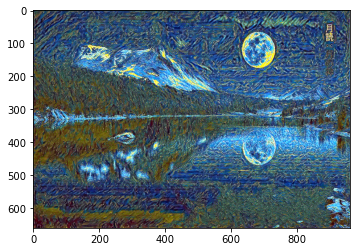

Epoch: [550]	 Content Loss: 0.5328	 Style Loss: 11.2426	


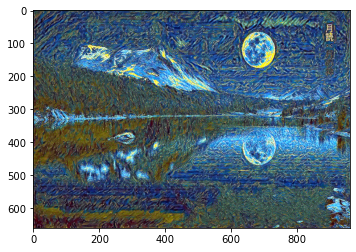

Epoch: [600]	 Content Loss: 0.5117	 Style Loss: 10.0892	


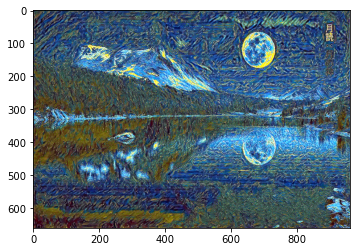

Epoch: [650]	 Content Loss: 0.4948	 Style Loss: 11.0803	


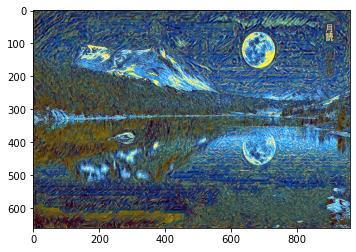

Epoch: [700]	 Content Loss: 0.4764	 Style Loss: 8.5679	


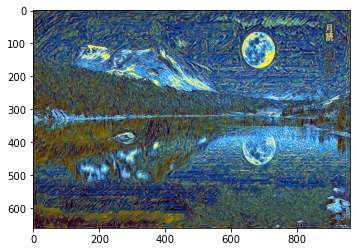

Epoch: [750]	 Content Loss: 0.4630	 Style Loss: 8.2269	


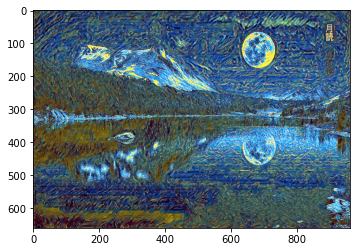

Epoch: [800]	 Content Loss: 0.4528	 Style Loss: 7.8429	


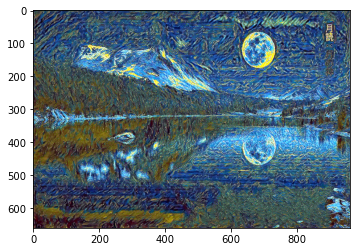

Epoch: [850]	 Content Loss: 0.4386	 Style Loss: 7.4788	


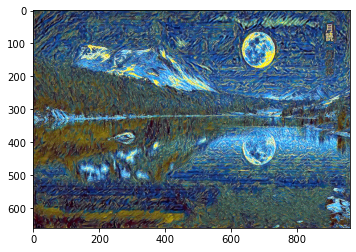

Epoch: [900]	 Content Loss: 0.4309	 Style Loss: 7.4680	


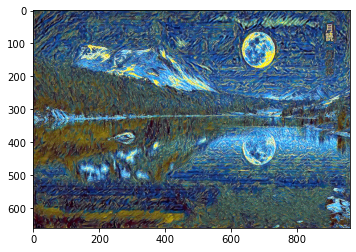

Epoch: [950]	 Content Loss: 0.4227	 Style Loss: 6.1279	


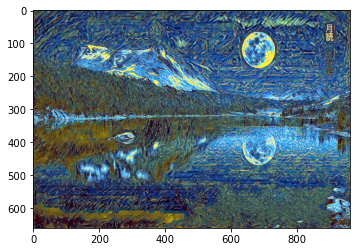

Epoch: [1000]	 Content Loss: 0.5200	 Style Loss: 23.0717	


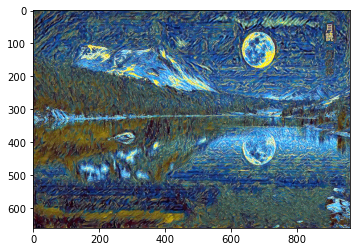

In [13]:
# Trainig
style_weight = 1000
content_weight = 10000
for epoch in range(1001):
    content_features = encoder(content_img)
    style_features = encoder(style_img)
    generated_feature = encoder(generate_img)
    # Calculate content loss
    content_loss = torch.mean((content_features[-1] - generated_feature[-1])**2)
    
    style_loss = 0
    for gf, sf in zip(generated_feature, style_features):
        _, c, h, w = gf.size()
        gram_gf = get_gram(gf)
        gram_sf = get_gram(sf)
        # calculate style loss
        style_loss += torch.mean((gram_gf - gram_sf)**2) / (c * h * w)
        
    loss = content_weight * content_loss + style_weight * style_loss  # Total loss
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch % 50 == 0:  # record log
        print('Epoch: [{}]\t Content Loss: {:.4f}\t Style Loss: {:.4f}\t'.format(epoch, content_loss.item(), style_loss.item()))
        inp = generate_img.detach().cpu().squeeze(0)
        inp = denormalize(inp)
        # save image
        plt.imsave('results_NST/nst7_' + str(epoch) + '.png', inp)
#         save_image(inp, 'results_NST/nst_' + str(epoch) + '.png')
        plt.imshow(inp)
        plt.show()

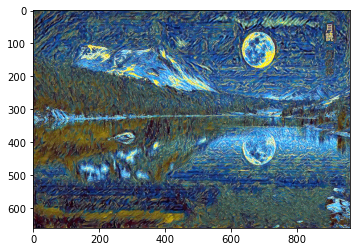

In [14]:
# View Generate image
inp = generate_img.detach().cpu().squeeze(0)
inp = denormalize(inp)
plt.imshow(inp)